### \*\*\*needs cleaning***

In [66]:
import pandas as pd
import numpy as np
import sys 
import os
import itertools
import time
import random

#import utils
sys.path.insert(0, '../utils/')
from utils_preprocess_v3 import *
from utils_modeling_v9 import *
from utils_plots_v2 import *

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

start_time = time.time()

In [67]:
data = pd.read_csv('../data/datasets_processed/VanAllen_data.csv', index_col = 0)
response = pd.read_csv('../data/datasets_processed/VanAllen_response.csv')
interactome = pd.read_csv('../data/interactomes/inbiomap_processed.txt', sep = '\t')

In [68]:
# get nodes from data and graph
data_nodes = data['node'].tolist()
interactome_nodes = list(set(np.concatenate((interactome['node1'], interactome['node2']))))

# organize data
organize = Preprocessing()
save_location = '../data/reduced_interactomes/reduced_interactome_VanAllen.txt'
organize.transform(data_nodes, interactome_nodes, interactome, data, save_location, load_graph = True)

In [69]:
# extract info from preprocessing
X = organize.sorted_X.T.values
y = response['PFS'].values.reshape(-1,1)
L_norm = organize.L_norm
L = organize.L

g = organize.g
num_to_node = organize.num_to_node

# split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [19]:
val_1, vec_1 = scipy.linalg.eigh(L_norm.toarray())
val_zeroed = val_1 - min(val_1) + 1e-8
L_rebuild = vec_1.dot(np.diag(val_zeroed)).dot(np.linalg.inv(vec_1))
X_train_lower = np.linalg.cholesky(L_rebuild)

In [70]:
L_rebuild.sum()

8355.891272938601

In [71]:
# check
X_train_lower.dot(X_train_lower.T).sum()

8355.891272938625

In [72]:
L_norm.sum()

8355.891101468758

# Lasso + LapRidge

In [79]:
# hyperparameters
alpha1_list = np.logspace(-1,0,15)
alpha2_list = np.logspace(-1,2,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
alpha_pairs = list(itertools.product(alpha1_list, alpha2_list))

In [80]:
def loss_fn(X,Y, L, alpha1, alpha2, beta):
    return 0.5/(len(X)) * cp.norm2(cp.matmul(X, beta) - Y)**2 + \
           alpha1 * cp.norm1(beta) + \
           alpha2 * cp.sum(cp.quad_form(beta,L)) 

def run(pair, X_train, y_train, L_norm):
    beta = cp.Variable(X_train.shape[1])
    alpha1 = cp.Parameter(nonneg=True)
    alpha2 = cp.Parameter(nonneg=True)
    alpha1.value = pair[0]
    alpha2.value = pair[1]
    
    problem = cp.Problem(cp.Minimize(loss_fn(X_train, y_train, L_norm, alpha1, alpha2, beta )))
    problem.solve(solver = cp.SCS, verbose=True, max_iters=50000)

    return beta.value

In [ ]:
betas = Parallel(n_jobs=15, verbose=10)(delayed(run)(alpha_pairs[i],
                                                       X_train,
                                                       y_train,
                                                       L_norm) for i in range(len(alpha_pairs)))

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed: 157.3min
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed: 296.1min
/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed: 438.3min
[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed: 643.4min
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed: 775.1min
[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed: 996.8min
[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed: 1246.4min
[Parallel(n_jobs=15)]: Done  83 tasks      | elapsed: 1516.3min


In [95]:
feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in betas]
regr = LinearRegression()
scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
train_scores = [i[0] for i in scores]
test_scores = [i[1] for i in scores]

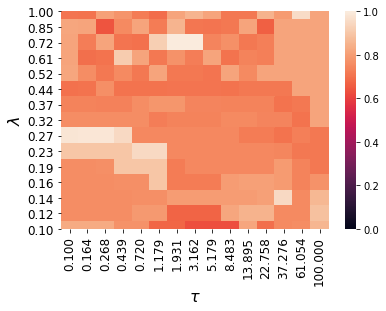

In [96]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha1_list, alpha2_list, save_location = None)

In [97]:
np.where(test_scores == min(test_scores))

(array([7, 9]),)

In [98]:
min(test_scores)

0.629095897187934

/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


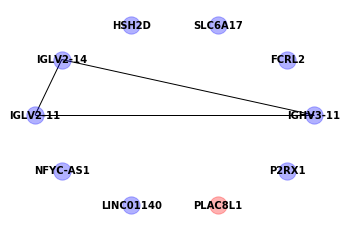

In [100]:
getTranslatedNodes(feats[7], betas[7][feats[7]], num_to_node, g, )

# MCP + LapRidge

In [50]:
# define training params
alpha1_list = np.logspace(-3,-2,15)
alpha2_list = np.logspace(-1,2,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
alpha_list_pairs = list(itertools.product(alpha1_list, alpha2_list))

In [51]:
results = {}
feats_list = []
betas = []
for i in alpha2_list:
    X_train_new = np.vstack((X_train, np.sqrt(i)*X_train_lower))
    y_train_new = np.concatenate((y_train, np.zeros(len(X_train_lower))))
    s = pycasso.Solver(X_train_new, y_train_new, lambdas=alpha1_list, penalty = 'mcp')
    s.train()
    beta = s.coef()['beta']
    
    betas += [i for i in beta]
    
    feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in beta]
    feats_list += feats
    print([len(i) for i in feats])
    
    regr = LinearRegression()
    scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
    
    results[i] = scores

Training is over.
[10, 9, 6, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 9, 6, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 9, 6, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 6, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 9, 6, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 9, 6, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 7, 5, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 8, 5, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 8, 5, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 8, 6, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 8, 6, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 6, 5, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 9, 7, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 8, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [52]:
train_scores = []
test_scores = []
for k,v in results.items():
    train_scores += [i[0] for i in v]
    test_scores += [i[1] for i in v]

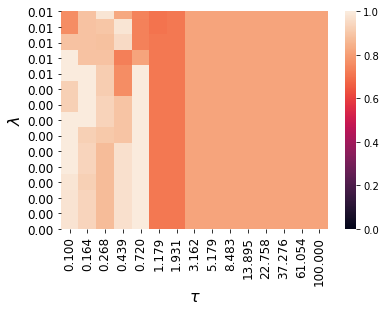

In [53]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha1_list, alpha2_list, save_location = None)

In [54]:
min(test_scores)

0.7039580670406117

In [55]:
np.where(test_scores == min(test_scores))

(array([200, 215]),)

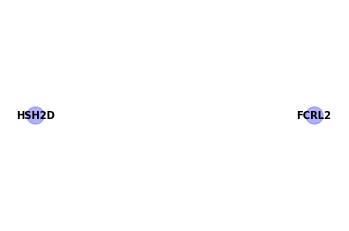

In [56]:
getTranslatedNodes(feats_list[215], betas[215][feats_list[215]], num_to_node, g)

# SCAD + LapRidge

In [40]:
# define training params
alpha1_list = np.logspace(-3,-2,15)
alpha2_list = np.logspace(-1,2,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
alpha_list_pairs = list(itertools.product(alpha1_list, alpha2_list))

In [41]:
results = {}
feats_list = []
betas = []
for i in alpha2_list:
    X_train_new = np.vstack((X_train, np.sqrt(i)*X_train_lower))
    y_train_new = np.concatenate((y_train, np.zeros(len(X_train_lower))))
    s = pycasso.Solver(X_train_new, y_train_new, lambdas=alpha1_list, penalty = 'scad')
    s.train()
    beta = s.coef()['beta']
    
    betas += [i for i in beta]
    
    feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in beta]
    feats_list += feats
    print([len(i) for i in feats])
    
    regr = LinearRegression()
    scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
    
    results[i] = scores

Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 8, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 8, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 8, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 4, 1, 0,

In [42]:
train_scores = []
test_scores = []
for k,v in results.items():
    train_scores += [i[0] for i in v]
    test_scores += [i[1] for i in v]

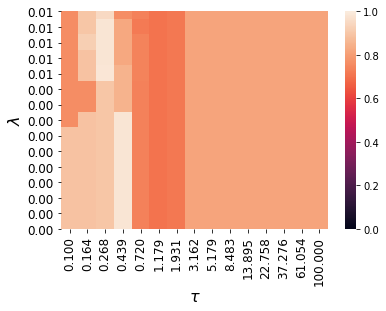

In [43]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha1_list, alpha2_list, save_location = None)

In [44]:
min(test_scores)

0.7039580670406117

In [45]:
np.where(test_scores == min(test_scores))

(array([  5,  20,  35,  50,  65,  80,  95, 110, 125, 140, 155, 170, 185,
        200]),)

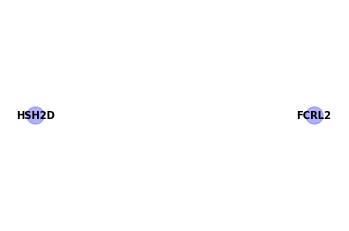

In [47]:
getTranslatedNodes(feats_list[5], betas[5][feats_list[5]], num_to_node, g)